# Dirichlet model fitting to nutrient productivity
Based on http://dirichletreg.r-forge.r-project.org/


In [1]:
# Import python packages
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import theano as T
import ternary
import theano.tensor as tt
import seaborn as sns
import scipy as sp
import pdb
import os
import arviz as az
from matplotlib.patches import Ellipse, transforms
from itertools import combinations
#import ternary

# Helper functions
def indexall(L):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    return poo,Ix

# Helper functions
def indexall_B(L,B):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    a, b = poo.index(B), 0
    poo[b], poo[a] = poo[a], poo[b]
    
    Ix[Ix==b] = -1
    Ix[Ix==a] = 0
    Ix[Ix==-1] = a
    return poo,Ix

def subindexall(short,long):
    poo = []
    out = []
    for s,l in zip(short,long):
        if not l in poo:
            poo.append(l)
            out.append(s)
    return indexall(out)

match = lambda a, b: np.array([ b.index(x) if x in b else None for x in a ])
grep = lambda s, l: np.array([i for i in l if s in i])

# Function to standardize covariates
def stdize(x):
    return (x-np.mean(x))/(2*np.std(x))

# Coefficient of variation
cv =  lambda x: np.var(x) / np.mean(x)

# Posterior draws for each covariate, save as csv
def extract_con(mu, varname):

    # covariate trace
    mus = trace_dm[mu]

    # get posterior mean
    mu_0 = pd.DataFrame(mus.T.mean(1))
    mu_0.to_csv('prod/posterior_'+varname+'.csv', index=False)

    # get HPDI
    Ex_hpd = az.hdi(mus).T
    Ex_hpd_lo = pd.DataFrame(Ex_hpd[0,:])
    Ex_hpd_hi = pd.DataFrame(Ex_hpd[1,:])
    Ex_hpd_lo.to_csv('prod/posterior_'+varname+'_hpd_lo.csv', index=False)
    Ex_hpd_hi.to_csv('prod/posterior_'+varname+'_hpd_hi.csv', index=False)

Dataset are proportion of nutrient productivity by fish functional groups, for zinc.mg

In [2]:
# Import data
nut = pd.read_csv("zinc.mg_reef_unscaled.csv")
nut.tail()

,nut_turnover,nut_prod_day_ha,prod_day_ha,biomass_kgha,nutrient,nutrient_lab,country,site,year,hard_coral,...,bare_substrate,rubble,reef_type,reef_zone,depth,management_rules,grav_nc,sediment,nutrient_load,pop_count
370,0.008950,15.554430,1385.208981,1319.246667,zinc.mg,Zinc,Solomon Islands,Zaira 3,2019,38.33,...,0.00,0.33,fringing,fore reef,9.17,restriction,-0.848048,1.637899,0.0,2.767539
371,0.006997,22.630123,1758.883334,2128.230000,zinc.mg,Zinc,Solomon Islands,Zaira 4,2019,28.00,...,0.00,0.00,fringing,fore reef,8.53,restriction,-0.890715,1.479962,0.0,2.628436
372,0.009404,50.822523,5268.756988,5462.975000,zinc.mg,Zinc,Solomon Islands,Zaira F 1,2019,39.00,...,0.33,1.00,barrier,fore reef,10.33,restriction,-0.848048,1.637899,0.0,2.767539
373,0.015976,62.605911,5506.546557,3113.270000,zinc.mg,Zinc,Solomon Islands,Zaira F 2,2019,30.33,...,0.00,4.67,barrier,fore reef,11.00,restriction,-0.848048,1.637899,0.0,2.767539
374,0.007112,27.209307,2857.077274,3607.505000,zinc.mg,Zinc,Solomon Islands,Zaira F 3,2019,28.67,...,0.00,7.67,barrier,fore reef,9.00,restriction,-0.848048,1.257863,0.0,2.048300


In [56]:
# Import data
nut = pd.read_csv("zinc.mg_reef_unscaled.csv")
nut.management_rules = nut.country + nut.management_rules

# Grab y variable
y = nut['prod_day_ha'].to_numpy()
ylog = np.log(y)

# # identify predictors
hc = stdize(nut.hard_coral).to_numpy()
ma = stdize(nut.macroalgae).to_numpy()
bs = stdize(nut.bare_substrate).to_numpy()
ta = stdize(nut.turf_algae).to_numpy()
rub = stdize(nut.rubble).to_numpy()
pop = stdize(nut.pop_count).to_numpy()
rt = pd.Categorical(nut.reef_type)
grav_nc = stdize(nut.grav_nc).to_numpy()
nl = stdize(nut.nutrient_load).to_numpy()
sed = stdize(nut.sediment).to_numpy()
dep = stdize(nut.depth).to_numpy()

## categorical levels
reef_type = list(np.sort(pd.unique(nut["reef_type"])))
rt = np.array([reef_type.index(x) for x in nut["reef_type"]])

reef_zone = list(np.sort(pd.unique(nut["reef_zone"])))
rz = np.array([reef_zone.index(x) for x in nut["reef_zone"]])

# country = list(np.sort(pd.unique(nut["country"])))
# c = np.array([country.index(x) for x in nut["country"]])

manage = list(np.sort(pd.unique(nut["management_rules"])))
mr = np.array([manage.index(x) for x in nut["management_rules"]])

# if manage nested in country, use subindexall
country,c = subindexall(nut["country"], nut["management_rules"])
# manage,mr = indexall(nut["management_rules"])

# site is almost n = 1 for all, so would not converge sensibly
manage

['Belizeno-take',
 'Belizerestriction',
 'Fijino-take',
 'Fijirestriction',
 'Madagascarno-take',
 'Madagascaropen-access',
 'Madagascarrestriction',
 'Solomon Islandsno-take',
 'Solomon Islandsrestriction']

Now build the model

In [19]:
coords={'reef_type':reef_type, 'country':country}

Nsd = 1

with pm.Model(coords=coords) as BDM:
    intercept = pm.Normal('intercept', 0, Nsd)
    
    # conts
    hard_coral = pm.Normal('hard_coral', 0, Nsd)
    macroalgae = pm.Normal('macroalgae', 0, Nsd)
    bare_sub = pm.Normal('bare_sub', 0, Nsd)
    turf = pm.Normal('turf', 0, Nsd)
    rubble = pm.Normal('rubble', 0, Nsd)
    population = pm.Normal('population', 0, Nsd)
    gravity = pm.Normal('gravity', 0, Nsd)
    sediment = pm.Normal('sediment', 0, Nsd)
    nut_load = pm.Normal('nut_load', 0, Nsd)
    depth = pm.Normal('depth', 0, Nsd)
    
    # cats
    reeftype_x = pm.Normal("reeftype_x", 0, Nsd, shape = len(reef_type))
    reefzone_x = pm.Normal("reefzone_x", 0, Nsd, shape = len(reef_zone))
    
    # country nested in global intercept
#     σ_c = pm.Exponential('Sigma_country', 1)
#     β0_cnc = pm.Normal('β0_cnc', 0, Nsd, shape = len(country))
#     β0_c = pm.Normal('β0_c', intercept+β0_cnc*σ_c, shape = len(country))

#     # Management nested in country 
#     σ_m = pm.Exponential('Sigma_manage', 1)
    β0_managenc = pm.Normal('β0_managenc', 0, Nsd, shape = len(manage))
#     β0_manage = pm.Normal('β0_manage', β0_c[c]+β0_managenc*σ_m, shape = len(manage))

    μ = pm.Deterministic('mu', 
                                        intercept +
                                         β0_managenc[mr] +
#                                          β0_c[c] +
#                                          manage_x[mr] +
                                         reeftype_x[rt] + reefzone_x[rz] +
                                         hard_coral*hc+macroalgae*ma+
                                         bare_sub*bs+turf*ta+rubble*rub+
                                         gravity*grav_nc + population*pop+
                                         sediment*sed + nut_load*nl +
                                         depth*dep)
    
    σ = pm.Exponential('Sigma', 1)
    Yi = pm.Normal('Yi', mu=μ, sigma=σ, observed=ylog)
    
    # Covariate predictions
    gravG = np.linspace(min(grav_nc),max(grav_nc), num=100)
    μ2 = pm.Deterministic('mu2', tt.exp(intercept + gravity*gravG))
    
    coralG = np.linspace(min(hc),max(hc), num=100)
    μ3 = pm.Deterministic('mu3', tt.exp(intercept + hard_coral*coralG))
    
    macroG = np.linspace(min(ma),max(ma), num=100)
    μ4 = pm.Deterministic('mu4', tt.exp(intercept + macroalgae*macroG))
    
    bareG = np.linspace(min(bs),max(bs), num=100)
    μ5 = pm.Deterministic('mu5', tt.exp(intercept + bare_sub*bareG))
    
    turfG = np.linspace(min(ta),max(ta), num=100)
    μ6 = pm.Deterministic('mu6', tt.exp(intercept + turf*turfG))
    
    # manage is nested in country intercepts, so B0_manage covariate sample is the combined effect
    # B0_managenc covariate sample is the relative management effect
    manageG = np.linspace(0, 8, num = 9).astype(int)
    μ7 = pm.Deterministic('mu7', tt.exp(intercept + β0_managenc[manageG]))
    
    popG = np.linspace(min(pop),max(pop), num=100)
    μ8 = pm.Deterministic('mu8', tt.exp(intercept + population*popG))
    
    sedG = np.linspace(min(sed),max(sed), num=100)
    μ9 = pm.Deterministic('mu9', tt.exp(intercept + sediment*sedG))
    
    nlG = np.linspace(min(nl),max(nl), num=100)
    μ10 = pm.Deterministic('mu10', tt.exp(intercept + nut_load*nlG))
    
    rubG = np.linspace(min(rub),max(rub), num=100)
    μ11 = pm.Deterministic('mu11', tt.exp(intercept + rubble*rubG))
    
    # vectors of management type for each hard_coral gradient
    futureHC = np.repeat(coralG, 9)
    futureG = np.tile(manageG, 100)
    μ12 = pm.Deterministic('mu12', tt.exp(intercept + β0_managenc[futureG] + hard_coral*futureHC))

In [20]:
for RV in BDM.basic_RVs:
    print(RV.name, RV.logp(BDM.test_point))

intercept -0.9189385332046727
hard_coral -0.9189385332046727
macroalgae -0.9189385332046727
bare_sub -0.9189385332046727
turf -0.9189385332046727
rubble -0.9189385332046727
population -0.9189385332046727
gravity -0.9189385332046727
sediment -0.9189385332046727
nut_load -0.9189385332046727
depth -0.9189385332046727
reeftype_x -4.594692666023363
reefzone_x -2.756815599614018
β0_managenc -8.270446798842052
Sigma_log__ -1.0596601002984287
Yi -26432.53926556303


In [21]:
with BDM:
    trace_dm = pm.sample()

/opt/miniconda3/lib/python3.7/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [Sigma, β0_managenc, reefzone_x, reeftype_x, depth, nut_load, sediment, gravity, population, rubble, turf, bare_sub, macroalgae, hard_coral, intercept]


/opt/miniconda3/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/miniconda3/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/miniconda3/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 50 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [7]:
pm.summary(trace_dm, var_names=['~^mu'], filter_vars="regex")

/opt/miniconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,4.670,0.637,3.460,5.833,0.017,0.012,1433.0,1522.0,1.00
hard_coral,0.324,0.122,0.106,0.567,0.003,0.002,1734.0,1938.0,1.00
macroalgae,-0.174,0.112,-0.387,0.028,0.003,0.002,1679.0,1969.0,1.00
bare_sub,-0.080,0.101,-0.277,0.105,0.002,0.002,2540.0,1784.0,1.00
turf,0.011,0.105,-0.192,0.199,0.002,0.002,2163.0,2271.0,1.00
rubble,-0.034,0.109,-0.242,0.171,0.002,0.002,2080.0,2017.0,1.00
population,-0.592,0.128,-0.842,-0.365,0.002,0.002,3003.0,1862.0,1.00
gravity,0.258,0.107,0.068,0.468,0.002,0.001,2775.0,2047.0,1.00
sediment,0.222,0.130,-0.016,0.462,0.002,0.002,3044.0,2079.0,1.00
nut_load,-0.059,0.103,-0.250,0.136,0.002,0.002,3083.0,2370.0,1.00


In [8]:
# Export summary stats
tmp = pm.summary(trace_dm, var_names=['~^Sigma', '~^mu'], hdi_prob=0.95, filter_vars="regex")
varnames = np.array(list(tmp.index), dtype=object)
# varnames[match(grep('β0_c',list(varnames)),list(varnames))] = np.array(list(country*2))
varnames[match(grep('β0_manage',list(varnames)),list(varnames))] = np.array(list(manage*1))
varnames[match(grep('reeftype_x',list(varnames)),list(varnames))] = reef_type
varnames[match(grep('reefzone_x',list(varnames)),list(varnames))] = reef_zone

tmp['varname'] = list(varnames)


tmp.to_csv('prod/posterior_summary.csv')

tmp = pm.summary(trace_dm, var_names=['~^Sigma', '~^mu'], hdi_prob=0.5, filter_vars="regex")
varnames = np.array(list(tmp.index), dtype=object)
# varnames[match(grep('β0_c',list(varnames)),list(varnames))] = np.array(list(country*2))
varnames[match(grep('β0_manage',list(varnames)),list(varnames))] = np.array(list(manage*1))
varnames[match(grep('reeftype_x',list(varnames)),list(varnames))] = reef_type
varnames[match(grep('reefzone_x',list(varnames)),list(varnames))] = reef_zone

tmp['varname'] = list(varnames)

tmp.to_csv('prod/posterior_summary_50.csv')

/opt/miniconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/opt/miniconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


(Text(0, 0.5, 'Observed'), Text(0.5, 0, 'Predicted'))

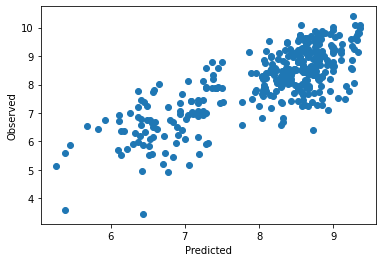

In [10]:
# Grab expected alphas
mu = trace_dm['mu'].T
mu_0 = mu.mean(1)

## Predicted vs. observed
plt.scatter(mu_0,ylog) 
# plt.scatter(np.exp(mu_0), np.exp(ylog))
plt.ylabel('Observed'),plt.xlabel('Predicted')

In [57]:
# extract posterior dists for covariates
out = pm.trace_to_dataframe(trace_dm)
varnames = np.array(list(out), dtype=object)
# varnames[match(grep('β0_c',list(varnames)),list(varnames))] = np.array(list(np.repeat(country, nfg))*2)
varnames[match(grep('reeftype_x',list(varnames)),list(varnames))] = np.repeat(reef_type, 1)
varnames[match(grep('reefzone_x',list(varnames)),list(varnames))] = np.repeat(reef_zone, 1)
# varnames[match(grep('manage_x',list(varnames)),list(varnames))] = np.repeat(manage, nfg)
varnames[match(grep('β0_managenc',list(varnames)),list(varnames))] = np.array(list(np.repeat(manage, 1))*1)

out.columns=varnames
out = out.drop(out.filter(regex='mu').columns, axis=1)
out.to_csv('prod/prod_posterior_trace.csv', index=False)

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


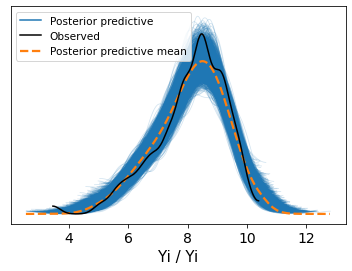

In [12]:
## posterior predictive distribution
with BDM:
    ppc = pm.sample_posterior_predictive(
        trace_dm, random_seed=43
    )

with BDM:
    az.plot_ppc(az.from_pymc3(posterior_predictive=ppc))

In [22]:
## extract posterior predicted 
extract_con(mu='mu2', varname = 'gravity')
extract_con(mu='mu3', varname = 'hard_coral')
extract_con(mu='mu4', varname = 'macroalgae')
extract_con(mu='mu5', varname = 'bare_substrate')
extract_con(mu='mu6', varname = 'turf')
extract_con(mu='mu7', varname = 'manage')
extract_con(mu='mu8', varname = 'pop')
extract_con(mu='mu9', varname = 'sediment')
extract_con(mu='mu10', varname = 'nut_load')
extract_con(mu='mu11', varname = 'rubble')
extract_con(mu='mu12', varname = 'future_hc')

/opt/miniconda3/lib/python3.7/site-packages/arviz/stats/stats.py:459: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,
